In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm

In [2]:
#%load_ext autoreload
#%autoreload 2


import sys
sys.path.append("../../mrf-sim/")
sys.path.append("../../epgpy/")
sys.path.append("../../machines/")
sys.path.append("../../mutools/")
sys.path.append("../../dicomstack/")

#import matplotlib
#matplotlib.use("TkAgg")
from mrfsim import T1MRF
from image_series import *
from utils_mrf import regression_paramMaps_ROI,buildROImask,plot_evolution_params,compare_paramMaps
import json
from finufft import nufft1d1,nufft1d2
from scipy import signal,interpolate
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
from movements import *
from dictoptimizers import *
from copy import copy,deepcopy
import math
%matplotlib inline

I was here


In [46]:
dictfile=r"../mrf175_SimReco2.dict"
keys,signals = read_mrf_dict(dictfile,FF_list=None,aggregate_components=False)

In [47]:
keys

[(550, 300.0, 0.3, 0.06),
 (550, 300.0, 0.3, 0.045),
 (550, 300.0, 0.3, 0.03),
 (550, 300.0, 0.3, 0.015),
 (550, 300.0, 0.3, -0.0),
 (550, 300.0, 0.3, -0.015),
 (550, 300.0, 0.3, -0.03),
 (550, 300.0, 0.3, -0.045),
 (550, 300.0, 0.3, -0.06),
 (550, 300.0, 0.35, 0.06),
 (550, 300.0, 0.35, 0.045),
 (550, 300.0, 0.35, 0.03),
 (550, 300.0, 0.35, 0.015),
 (550, 300.0, 0.35, -0.0),
 (550, 300.0, 0.35, -0.015),
 (550, 300.0, 0.35, -0.03),
 (550, 300.0, 0.35, -0.045),
 (550, 300.0, 0.35, -0.06),
 (550, 300.0, 0.4, 0.06),
 (550, 300.0, 0.4, 0.045),
 (550, 300.0, 0.4, 0.03),
 (550, 300.0, 0.4, 0.015),
 (550, 300.0, 0.4, -0.0),
 (550, 300.0, 0.4, -0.015),
 (550, 300.0, 0.4, -0.03),
 (550, 300.0, 0.4, -0.045),
 (550, 300.0, 0.4, -0.06),
 (550, 300.0, 0.45, 0.06),
 (550, 300.0, 0.45, 0.045),
 (550, 300.0, 0.45, 0.03),
 (550, 300.0, 0.45, 0.015),
 (550, 300.0, 0.45, -0.0),
 (550, 300.0, 0.45, -0.015),
 (550, 300.0, 0.45, -0.03),
 (550, 300.0, 0.45, -0.045),
 (550, 300.0, 0.45, -0.06),
 (550, 300.0, 

In [48]:
len(keys)

15390

In [59]:
15390/135

114.0

In [49]:
X = np.array(keys)

In [50]:
Y=np.array(signals)

In [51]:
Y.shape

(15390, 175, 2)

In [58]:
water_signals

array([[-0.07935323-6.85321686e-18j, -0.07476058+4.57776508e-18j,
        -0.07036817+4.30880755e-18j, ...,  0.02487661-1.52325295e-18j,
         0.0253246 -1.55068423e-18j,  0.02574923-1.57668546e-18j],
       [-0.07931087-6.85581095e-18j, -0.07466384+4.57184183e-18j,
        -0.07022104+4.29979853e-18j, ...,  0.02536465-1.55313713e-18j,
         0.02581722-1.58084849e-18j,  0.02624593-1.60709968e-18j],
       [-0.07926629-6.85854072e-18j, -0.07456208+4.56561092e-18j,
        -0.07006632+4.29032497e-18j, ...,  0.02587177-1.58418928e-18j,
         0.02632889-1.61217974e-18j,  0.02676166-1.63867882e-18j],
       ...,
       [-0.0141867 +1.79145725e-02j, -0.01270414+1.60424294e-02j,
        -0.01129814+1.42669753e-02j, ..., -0.00379043-2.14790669e-02j,
        -0.00380115-2.15398173e-02j, -0.003811  -2.15956158e-02j],
       [-0.01416707-1.78897780e-02j, -0.01265995-1.59866308e-02j,
        -0.01123197-1.41834233e-02j, ..., -0.00379829+2.15236104e-02j,
        -0.00380873+2.15827534e-02j

In [65]:
water_signals,index_water = np.unique(Y[:,:,0],axis=0,return_inverse=True)
fat_signals,index_fat=np.unique(Y[:,:,1],axis=0,return_inverse=True)

(15390, 1)

In [60]:
index_fat

array([134, 119, 114, ...,   1,   0,   2])

In [53]:
nb_sig_water = water_signals.shape[0]

nb_sig_fat = fat_signals.shape[0]

In [56]:
index_fat.shape

(15390,)

In [11]:
def get_groups(signals,N_elements_per_group,pca_fgm=None):
    nb_signals = signals.shape[0]
    N_groups = int(nb_signals/N_elements_per_group)
    mean_signal = np.mean(signals,axis=1)
    std_signal = np.std(signals,axis=1)
    signals_normalized = (signals-mean_signal.reshape(-1,1))/std_signal.reshape(-1,1)
    S = signals[0]
    
    group_signals=np.zeros((N_groups+math.ceil(nb_signals/N_elements_per_group-N_groups),signals.shape[1]),dtype=np.complex128)
    group_indices=np.zeros((N_groups+math.ceil(nb_signals/N_elements_per_group-N_groups),N_elements_per_group),dtype=int)
    #group_indices={}
    group_pca={}
    index_already_assigned = []
    mask=np.ones(signals.shape[0], dtype=bool)
    for j in tqdm(range(N_groups)):
        correls=np.matmul(signals_normalized[:,:],((S-S.mean())/S.std()).conj()).real.reshape(1,-1)
        highest_correl_index = np.argsort(correls)[0]
        highest_correl_index_filtered = np.array([e for e in highest_correl_index if e not in index_already_assigned])[-N_elements_per_group:]
        #print(highest_correl_index_filtered)
        S = np.mean(signals[highest_correl_index_filtered,:],axis=0)
        index_already_assigned = index_already_assigned + list(highest_correl_index_filtered)
        #mask[index_already_assigned]=False
        group_signals[j,:]=copy(S)
        group_indices[j,:]=highest_correl_index_filtered
        
        if pca_fgm is not None:
            pca_fgm.fit(signals[highest_correl_index_filtered,:])
            X_pca_current=pca_fgm.transform(signals[highest_correl_index_filtered,:])
            #components = pca_fgm.components_
            group_pca[j]=(deepcopy(pca_fgm),X_pca_current)
    
    nb_unassigned_signals = nb_signals - len(index_already_assigned)
    if nb_unassigned_signals>0:
        print("There were {} unassigned signals".format(nb_unassigned_signals))
        raise ValueError("This should not happen")
        #index_unassigned = np.array(list(set(range(nb_signals))-set(index_already_assigned)))
        #S = np.mean(signals[index_unassigned,:],axis=0)
        #group_signals[-1,:]=copy(S)
        #group_indices[N_groups]=index_unassigned
        #if pca_fgm is not None:
        #    pca_fgm.fit(signals[index_unassigned,:])
        #    X_pca_current = pca_fgm.transform(signals[index_unassigned,:])
        #    #components = pca_fgm.components_
        #    group_pca[N_groups]=(deepcopy(pca_fgm),X_pca_current)
        
    return group_signals,group_indices,group_pca

In [ ]:
def get_groups_bi_comp(signals_water,signals_fat,N_elements_per_group,pca_fgm_water=None,pca_fgm_fat=None):
    nb_signals = signals.shape[0]
    N_groups = int(nb_signals/N_elements_per_group)
    mean_signal = np.mean(signals,axis=1)
    std_signal = np.std(signals,axis=1)
    signals_normalized = (signals-mean_signal.reshape(-1,1))/std_signal.reshape(-1,1)
    S = signals[0]
    
    group_signals=np.zeros((N_groups+math.ceil(nb_signals/N_elements_per_group-N_groups),signals.shape[1]),dtype=np.complex128)
    group_indices=np.zeros((N_groups+math.ceil(nb_signals/N_elements_per_group-N_groups),N_elements_per_group),dtype=int)
    #group_indices={}
    group_pca={}
    index_already_assigned = []
    mask=np.ones(signals.shape[0], dtype=bool)
    for j in tqdm(range(N_groups)):
        correls=np.matmul(signals_normalized[:,:],((S-S.mean())/S.std()).conj()).real.reshape(1,-1)
        highest_correl_index = np.argsort(correls)[0]
        highest_correl_index_filtered = np.array([e for e in highest_correl_index if e not in index_already_assigned])[-N_elements_per_group:]
        #print(highest_correl_index_filtered)
        S = np.mean(signals[highest_correl_index_filtered,:],axis=0)
        index_already_assigned = index_already_assigned + list(highest_correl_index_filtered)
        #mask[index_already_assigned]=False
        group_signals[j,:]=copy(S)
        group_indices[j,:]=highest_correl_index_filtered
        
        if pca_fgm is not None:
            pca_fgm.fit(signals[highest_correl_index_filtered,:])
            X_pca_current=pca_fgm.transform(signals[highest_correl_index_filtered,:])
            #components = pca_fgm.components_
            group_pca[j]=(deepcopy(pca_fgm),X_pca_current)
    
    nb_unassigned_signals = nb_signals - len(index_already_assigned)
    if nb_unassigned_signals>0:
        print("There were {} unassigned signals".format(nb_unassigned_signals))
        raise ValueError("This should not happen")
        #index_unassigned = np.array(list(set(range(nb_signals))-set(index_already_assigned)))
        #S = np.mean(signals[index_unassigned,:],axis=0)
        #group_signals[-1,:]=copy(S)
        #group_indices[N_groups]=index_unassigned
        #if pca_fgm is not None:
        #    pca_fgm.fit(signals[index_unassigned,:])
        #    X_pca_current = pca_fgm.transform(signals[index_unassigned,:])
        #    #components = pca_fgm.components_
        #    group_pca[N_groups]=(deepcopy(pca_fgm),X_pca_current)
        
    return group_signals,group_indices,group_pca

In [40]:
group_indices_water.shape

(81, 190)

In [45]:
water_signals.shape

/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(15390, 175)

In [42]:
index_water.shape

(15390,)

In [44]:
water_signals[group_indices_water[0]].shape

(190, 175)

In [13]:
pca_fgm_water=PCAComplex(n_components_=15)
group_signals_water,group_indices_water,group_pca_water=get_groups(water_signals,190,pca_fgm_water)

100%|██████████| 81/81 [01:51<00:00,  1.37s/it]


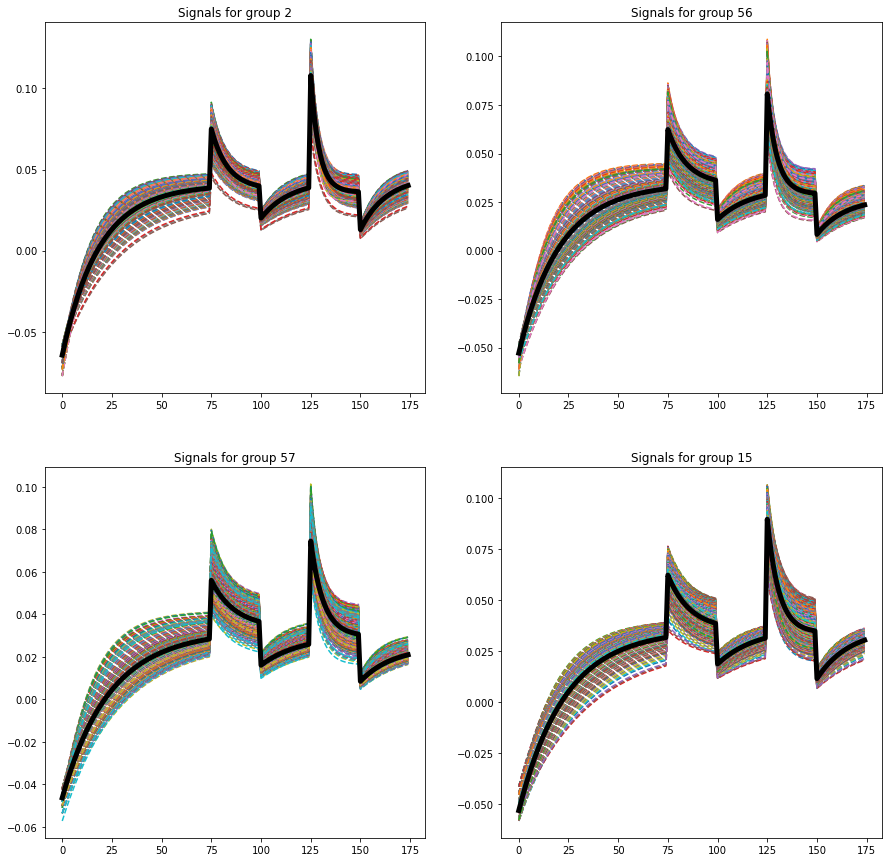

In [170]:
group_numbers=np.random.choice(range(group_signals_water.shape[0]),4,replace=False)
fig,ax=plt.subplots(2,2,figsize=(15,15))
nrow,ncol=ax.shape

metric=np.real

for i,num in enumerate(group_numbers):
    indices=group_indices_water[num].astype(int)
    mean_signal = group_signals_water[num]
    i_row=np.mod(i,nrow)
    i_col=int((i-i_row)/nrow)
    ax[i_row,i_col].plot(metric(water_signals)[indices,:].real.T,'--');
    ax[i_row,i_col].plot(metric(mean_signal),"k-",linewidth=5)
    ax[i_row,i_col].set_title("Signals for group {}".format(num))


/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


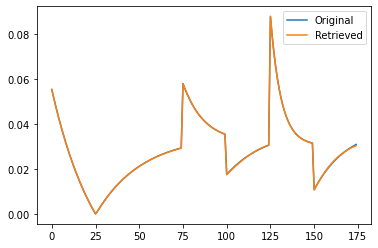

Group number : 49
Signal number : 137


In [171]:
group_number=np.random.choice(range(group_signals_water.shape[0]))
#group_number=80
pca_current,tranformed_signal= group_pca_water[group_number]
indices=group_indices_water[group_number]
signals = water_signals[indices]

i_plot=np.random.choice(range(signals.shape[0]))
pca_current.plot_retrieved_signal(signals,i=i_plot)
print("Group number : {}".format(group_number))
print("Signal number : {}".format(i_plot))

In [172]:
print(signals.shape)

(190, 175)


/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


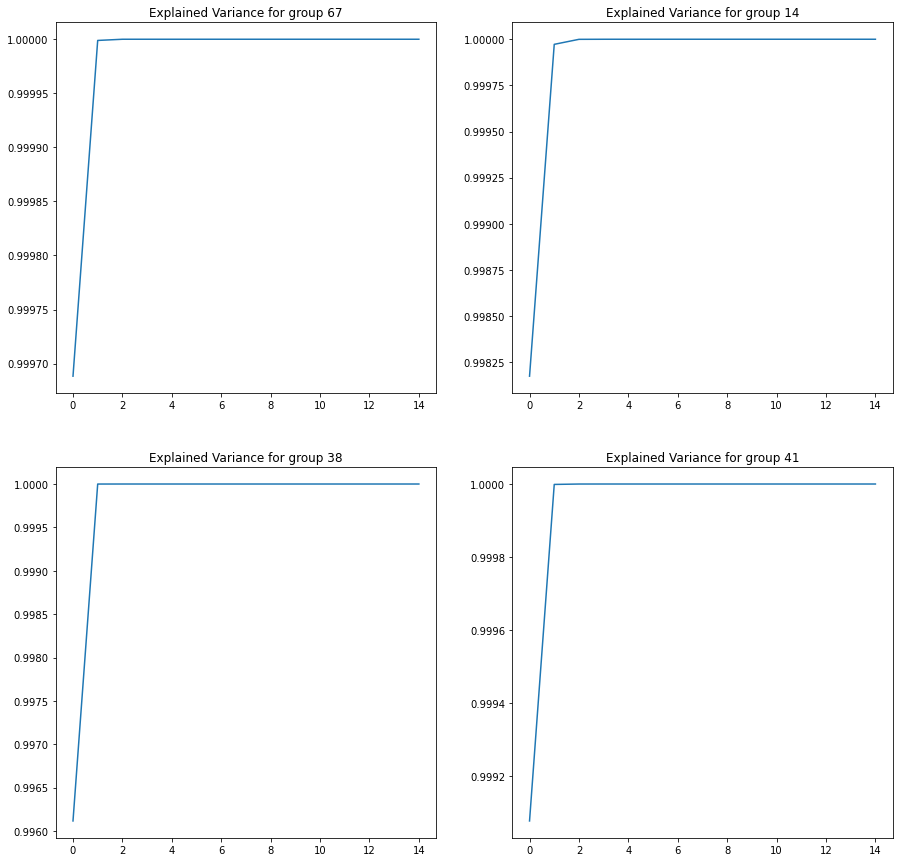

In [173]:
group_numbers=np.random.choice(range(group_signals_water.shape[0]),4,replace=False)
fig,ax=plt.subplots(2,2,figsize=(15,15))
nrow,ncol=ax.shape


for i,num in enumerate(group_numbers):
    pca_current,tranformed_signal= group_pca_water[num]
    i_row=np.mod(i,nrow)
    i_col=int((i-i_row)/nrow)
    ax[i_row,i_col].plot(pca_current.explained_variance_ratio_);
    ax[i_row,i_col].set_title("Explained Variance for group {}".format(num))

In [14]:

pca_fgm_fat=PCAComplex(n_components_=10)
group_signals_fat,group_indices_fat,group_pca_fat=get_groups(fat_signals,45,pca_fgm_fat)

100%|██████████| 3/3 [00:00<00:00, 295.19it/s]


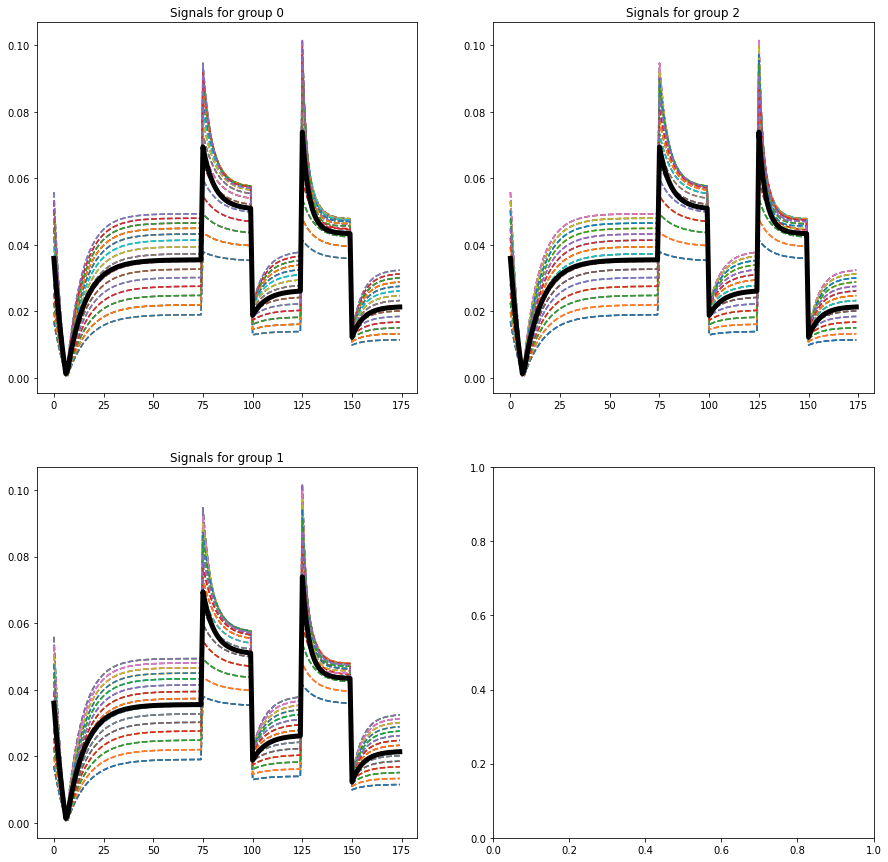

In [175]:
if group_signals_fat.shape[0]>4:
    group_numbers=np.random.choice(range(group_signals_fat.shape[0]),4,replace=False)
else:
    group_numbers=list(range(group_signals_fat.shape[0]))
fig,ax=plt.subplots(2,2,figsize=(15,15))
nrow,ncol=ax.shape

metric=np.abs

for i,num in enumerate(group_numbers):
    indices=group_indices_fat[num]
    mean_signal = group_signals_fat[num]
    i_row=np.mod(i,nrow)
    i_col=int((i-i_row)/nrow)
    ax[i_row,i_col].plot(metric(fat_signals)[indices,:].real.T,'--');
    ax[i_row,i_col].plot(metric(mean_signal),"k-",linewidth=5)
    ax[i_row,i_col].set_title("Signals for group {}".format(num))


In [92]:
pca_current.components_.shape

(175, 15)

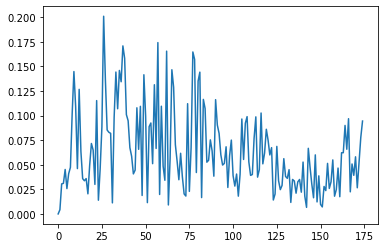

In [72]:
plt.plot(np.abs(pca_current.components_[:,26]))

/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


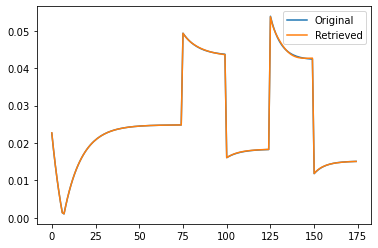

Group number : 2
Signal number : 32


In [176]:
group_number=np.random.choice(range(group_signals_fat.shape[0]))
#group_number=3
pca_current,tranformed_signal= group_pca_fat[group_number]
indices=group_indices_fat[group_number]
signals = fat_signals[indices]

i_plot=np.random.choice(range(signals.shape[0]))
pca_current.plot_retrieved_signal(signals,i=i_plot)
print("Group number : {}".format(group_number))
print("Signal number : {}".format(i_plot))

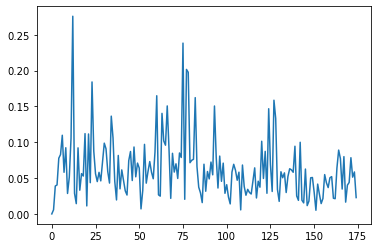

In [74]:
plt.plot(np.abs(pca_current.components_[:,26]))

In [177]:
group_numbers=np.random.choice(range(group_signals_fat.shape[0]),4,replace=False)
fig,ax=plt.subplots(2,2,figsize=(15,15))
nrow,ncol=ax.shape


for i,num in enumerate(group_numbers):
    pca_current,tranformed_signal= group_pca_fat[num]
    i_row=np.mod(i,nrow)
    i_col=int((i-i_row)/nrow)
    ax[i_row,i_col].plot(pca_current.explained_variance_ratio_);
    ax[i_row,i_col].set_title("Explained Variance for group {}".format(num))


/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Cannot take a larger sample than population when 'replace=False'

In [28]:
signals.shape

(27, 175)

# Signal Matching test

In [15]:
typ="SquarePhantom"
ph_num=1
file_matlab_paramMap = "../data/{}/Phantom{}/paramMap.mat".format(typ,ph_num)

size=(256,256)
useGPU_simulation=False
useGPU_dictsearch=False
threshold_pca=15


with open("../mrf_sequence.json") as f:
    sequence_config = json.load(f)

seq = T1MRF(**sequence_config)

In [16]:
m = MapFromFile("{}{}".format(type,ph_num), image_size=size, file=file_matlab_paramMap, rounding=True,gen_mode="loop")
m.buildParamMap()


Building Param Map


In [17]:

##### Simulating Ref Images
m.build_ref_images(seq)
#### Rebuilding the map from undersampled images
ntimesteps=175
nspoke=8
npoint = 512
radial_traj=Radial(ntimesteps=ntimesteps,nspoke=nspoke,npoint=npoint)
kdata = m.generate_kdata(radial_traj,useGPU=useGPU_simulation)
#np.save("./data/{}/Phantom{}/kdata.npy".format(type,ph_num),kdata)
#volumes_kdatamatlab = simulate_radial_undersampled_images(kdata_matlab,radial_traj,m.image_size,density_adj=True,useGPU=useGPU_simulation)
volumes = simulate_radial_undersampled_images(kdata,radial_traj,m.image_size,density_adj=True,useGPU=useGPU_simulation)
mask = build_mask_single_image(kdata,radial_traj,m.image_size)

  0%|          | 0/90 [00:00<?, ?it/s]

Building Ref Images
Simulating Water Signal
Simulation in loop mode


  0%|          | 0/90 [00:00<?, ?it/s]

Simulating Fat Signal
Simulation in loop mode


100%|██████████| 90/90 [00:25<00:00,  3.54it/s]


Build dictionary.
Building image series
Generating kdata


/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


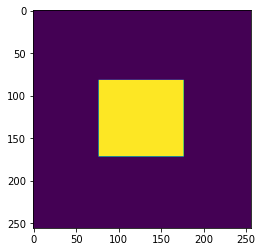

In [79]:
plt.imshow(mask)

In [80]:
water_signals.shape

/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(15390, 175)

In [18]:
volumes = volumes / np.linalg.norm(volumes, 2, axis=0)
all_signals = volumes[:, mask > 0]
volumes0 = volumes


/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
pca_water = PCAComplex(n_components_=threshold_pca)
pca_fat = PCAComplex(n_components_=threshold_pca)
pca_water.fit(water_signals)
pca_fat.fit(fat_signals)

transformed_array_water_unique = pca_water.transform(water_signals)
transformed_array_fat_unique = pca_fat.transform(fat_signals)



In [20]:
var_w_unique = np.sum(water_signals * water_signals.conj(), axis=1).real
var_f_unique = np.sum(fat_signals * fat_signals.conj(), axis=1).real
sig_wf = np.sum(water_signals[index_water] * fat_signals[index_fat].conj(), axis=1).real
var_w = var_w_unique[index_water]
var_f = var_f_unique[index_fat]
var_w = np.reshape(var_w, (-1, 1))
var_f = np.reshape(var_f, (-1, 1))
sig_wf = np.reshape(sig_wf, (-1, 1))

In [21]:
all_signals_unique, index_signals_unique = np.unique(all_signals, axis=1, return_inverse=True)
nb_signals_unique = all_signals_unique.shape[1]
nb_signals = all_signals.shape[1]

In [22]:
group_signals_water_pca=pca_water.transform(group_signals_water)
group_signals_fat_pca=pca_fat.transform(group_signals_fat)

In [23]:
group_signals_water_bc,group_signals_fat_bc=np.broadcast_arrays(np.expand_dims(group_signals_water_pca,axis=1),np.expand_dims(group_signals_fat_pca,axis=0))
group_signals_water_bc=group_signals_water_bc.reshape(-1,group_signals_water_pca.shape[-1])
group_signals_fat_bc=group_signals_fat_bc.reshape(-1,group_signals_fat_pca.shape[-1])

var_w_groups = np.sum(group_signals_water_bc * group_signals_water_bc.conj(), axis=1).real
var_f_groups = np.sum(group_signals_fat_bc * group_signals_fat_bc.conj(), axis=1).real
sig_wf_groups = np.sum( group_signals_water_bc* group_signals_fat_bc.conj(), axis=1).real

var_w_groups = np.reshape(var_w_groups, (-1, 1))
var_f_groups = np.reshape(var_f_groups, (-1, 1))
sig_wf_groups = np.reshape(sig_wf_groups, (-1, 1))

In [120]:
sig_wf_groups.shape

(243, 1)

In [24]:
transformed_all_signals_water = np.transpose(pca_water.transform(np.transpose(all_signals_unique)))
transformed_all_signals_fat = np.transpose(pca_fat.transform(np.transpose(all_signals_unique)))
sig_ws = np.matmul(group_signals_water_bc,
                                              transformed_all_signals_water.conj()).real
sig_fs = np.matmul(group_signals_fat_bc,
                                              transformed_all_signals_fat.conj()).real

In [25]:
sig_wf.shape

(15390, 1)

In [26]:
current_alpha_all_unique = (sig_wf_groups * sig_ws - var_w_groups * sig_fs) / (
                    (sig_ws + sig_fs) * sig_wf_groups - var_w_groups * sig_fs - var_f_groups * sig_ws)

current_alpha_all_unique = np.minimum(np.maximum(current_alpha_all_unique, 0.0), 1.0)

In [27]:
J_all = ((
                             1 - current_alpha_all_unique) * sig_ws + current_alpha_all_unique * sig_fs) / np.sqrt(
                (
                        1 - current_alpha_all_unique) ** 2 * var_w_groups + current_alpha_all_unique ** 2 * var_f_groups + 2 * current_alpha_all_unique * (
                        1 - current_alpha_all_unique) * sig_wf_groups)

In [28]:
group_pruning=5./100.
retained_groups=int(group_pruning*J_all.shape[0])

In [29]:
group_indices=np.unravel_index(np.argsort(J_all, axis=0)[::-1,:][:retained_groups],(group_signals_water.shape[0],group_signals_fat.shape[0]))

In [30]:
group_indices=np.array(group_indices)
water_group_indices_retained=group_indices[0]
fat_group_indices_retained=group_indices[1]


In [31]:
water_group_indices_retained[0].shape

(9000,)

In [183]:
group_indices_water

array([[  369,   792,  1341, ...,     2,     1,     0],
       [  429,  1510,  2047, ...,   803,   800,   797],
       [ 2763,  2352,  3067, ...,  1525,  1520,  1515],
       ...,
       [15354, 15246, 15142, ..., 14540, 14542, 14544],
       [ 7503,  7484,  7520, ..., 15240, 15242, 15244],
       [13531, 13535, 13538, ...,  6574,  5171,  5768]])

In [32]:

water_signals_in_group = water_signals[group_indices_water[water_group_indices_retained[0]]]
fat_signals_in_group = fat_signals[group_indices_fat[fat_group_indices_retained[0]]]

In [70]:
var_w[group_indices_water[water_group_indices_retained[0]]].shape

(9000, 190, 1)

In [71]:
var_f[group_indices_fat[fat_group_indices_retained[0]]].shape

(9000, 45, 1)

In [72]:
var_f.shape

(15390, 1)

In [77]:
var_f[:135]

array([[0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.22778625],
       [0.22778625],
       [0.227

In [76]:
var_f[135:(2*135)]

array([[0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.09523999],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.12224909],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.14972167],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.1768537 ],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.20302328],
       [0.22778625],
       [0.22778625],
       [0.227

In [83]:
split=500
current_water_signals_in_group=water_signals_in_group[:split]
current_fat_signals_in_group=fat_signals_in_group[:split]


In [84]:
current_water_signals_in_group.shape

(500, 190, 175)

In [1]:

water_signals_in_group_bc,fat_signals_in_group_bc=np.broadcast_arrays(np.expand_dims(current_water_signals_in_group,axis=2),np.expand_dims(current_fat_signals_in_group,axis=1))
water_signals_in_group_bc=water_signals_in_group_bc.reshape(current_water_signals_in_group.shape[0],-1,current_water_signals_in_group.shape[-1])
fat_signals_in_group_bc=fat_signals_in_group_bc.reshape(current_fat_signals_in_group.shape[0],-1,current_fat_signals_in_group.shape[-1])

var_w_in_group = np.sum(water_signals_in_group_bc * water_signals_in_group_bc.conj(), axis=1).real
var_f_in_group = np.sum(fat_signals_in_group_bc * fat_signals_in_group_bc.conj(), axis=1).real
sig_wf_in_group = np.sum( water_signals_in_group_bc* fat_signals_in_group_bc.conj(), axis=1).real

var_w_in_group = np.reshape(var_w_in_group, (-1, 1))
var_f_in_group = np.reshape(var_f_in_group, (-1, 1))
sig_wf_in_group = np.reshape(sig_wf_in_group, (-1, 1))



NameError: name 'np' is not defined

In [180]:


var_w_groups = np.sum(group_signals_water_bc * group_signals_water_bc.conj(), axis=1).real
var_f_groups = np.sum(group_signals_fat_bc * group_signals_fat_bc.conj(), axis=1).real
sig_wf_groups = np.sum( group_signals_water_bc* group_signals_fat_bc.conj(), axis=1).real

var_w_groups = np.reshape(var_w_groups, (-1, 1))
var_f_groups = np.reshape(var_f_groups, (-1, 1))
sig_wf_groups = np.reshape(sig_wf_groups, (-1, 1))

(9000, 190, 175)

In [185]:
water_signals[group_indices_water[water_group_indices_retained[0]]][index_water]

/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndexError: index 15388 is out of bounds for axis 0 with size 9000

In [82]:
var_f_unique[group_indices_fat[fat_group_indices_retained[0]]]

(9000, 45)

In [ ]:
var_w_unique[group_indices_water[water_group_indices_retained[0]]]

In [179]:
water_signals_in_group.shape

(9000, 190, 175)

In [181]:
fat_signals_in_group.shape

(9000, 45, 175)

In [154]:

for i in range(retained_groups):
    water_signals_in_group = water_signals[group_indices_water[water_group_indices_retained[i]]]
    fat_signals_in_group = fat_signals[group_indices_fat[fat_group_indices_retained[i]]]
    group_signals_water_bc,group_signals_fat_bc=np.broadcast_arrays(np.expand_dims(group_signals_water_pca,axis=1),np.expand_dims(group_signals_fat_pca,axis=0))
    group_signals_water_bc=group_signals_water_bc.reshape(-1,group_signals_water_pca.shape[-1])
    group_signals_fat_bc=group_signals_fat_bc.reshape(-1,group_signals_fat_pca.shape[-1])

    var_w_groups = np.sum(group_signals_water_bc * group_signals_water_bc.conj(), axis=1).real
    var_f_groups = np.sum(group_signals_fat_bc * group_signals_fat_bc.conj(), axis=1).real
    sig_wf_groups = np.sum( group_signals_water_bc* group_signals_fat_bc.conj(), axis=1).real

    var_w_groups = np.reshape(var_w_groups, (-1, 1))
    var_f_groups = np.reshape(var_f_groups, (-1, 1))
    sig_wf_groups = np.reshape(sig_wf_groups, (-1, 1))

{0: array([90, 91, 81, 82, 73, 74, 64, 65, 55, 57, 48, 51, 42, 43, 35, 37, 29,
        30, 22, 25, 17, 20, 12, 14,  8, 10,  4,  6,  2,  1, 88, 80, 71, 62,
        53, 47, 40, 33, 26, 21, 16, 11,  7,  3,  0]),
 1: array([107, 102,  96,  89,  84,  78,  72,  66,  59,  54,  49,  45,  31,
         41,  36,  99,  93,  85,  77,  69,  63,  56,  15,  50,  19,  44,
         24,  38,  28,  32,  94,  86,  76,  68,   5,  60,   9,  52,  13,
         46,  18,  39,  23,  34,  27]),
 2: array([134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122,
        121, 120, 119, 118, 117, 116, 115, 113, 112, 110, 109, 106,  95,
        104,  98, 103, 100, 114, 111, 108, 105, 101,  97,  58,  92,  61,
         87,  67,  83,  70,  79,  75])}

In [ ]:


values_results = []
keys_results = list(range(niter + 1)
for i in range(niter + 1)
    print("################# ITERATION : Number {} out of {} ####################".format(i, niter)
    print("Calculating optimal fat fraction and best pattern per signal for iteration {}".format(i))
    all_signals_unique, index_signals_unique = np.unique(all_signals, axis=1, return_inverse=True)
    nb_signals_unique = all_signals_unique.shape[1]
    nb_signals = all_signals.shape[1
    print("There are {} unique signals to match along {} water and {} fat components".format(nb_signals_unique,array_water_unique.shape[0],array_fat_unique.shape[0])
    duplicate_signals = True
    if nb_signals_unique == nb_signals:
        print("No duplicate signals")
        duplicate_signals = False
        all_signals_unique = all_signal
    num_group = int(nb_signals_unique / split) + 
    idx_max_all_unique = []
    alpha_optim = [
    for j in tqdm(range(num_group)):
        j_signal = j * split
        j_signal_next = np.minimum((j + 1) * split, nb_signals_unique
        if self.verbose:
            print("PCA transform")
            start = datetime.now(
        if not(useGPU_dictsearch)
            if pca:
                transformed_all_signals_water = np.transpose(pca_water.transform(np.transpose(all_signals_unique)))
                transformed_all_signals_fat = np.transpose(pca_fat.transform(np.transpose(all_signals_unique))
                sig_ws_all_unique = np.matmul(transformed_array_water_unique,
                                              transformed_all_signals_water[:, j_signal:j_signal_next].conj()).real
                sig_fs_all_unique = np.matmul(transformed_array_fat_unique,
                                              transformed_all_signals_fat[:, j_signal:j_signal_next].conj()).real
            else:
                sig_ws_all_unique = np.matmul(array_water_unique, all_signals_unique[:, j_signal:j_signal_next].conj()).real
                sig_fs_all_unique = np.matmul(array_fat_unique, all_signals_unique[:, j_signal:j_signal_next].conj()).rea
        else
            if pca
                transformed_all_signals_water = cp.transpose(
                    pca_water.transform(cp.transpose(cp.asarray(all_signals_unique)))).get()
                transformed_all_signals_fat = cp.transpose(pca_fat.transform(cp.transpose(cp.asarray(all_signals_unique)))).get(
                sig_ws_all_unique = (cp.matmul(cp.asarray(transformed_array_water_unique),
                                              cp.asarray(transformed_all_signals_water)[:,
                                              j_signal:j_signal_next].conj()).real).get()
                sig_fs_all_unique = (cp.matmul(cp.asarray(transformed_array_fat_unique),
                                              cp.asarray(transformed_all_signals_fat)[:,
                                              j_signal:j_signal_next].conj()).real).get()
            else
                sig_ws_all_unique = (cp.matmul(cp.asarray(array_water_unique),
                                              cp.asarray(all_signals_unique)[:, j_signal:j_signal_next].conj()).real).get()
                sig_fs_all_unique = (cp.matmul(cp.asarray(array_fat_unique),
                                              cp.asarray(all_signals_unique)[:, j_signal:j_signal_next].conj()).real).get(
        if self.verbose:
            end = datetime.now()
            print(end - start
        if self.verbose:
            print("Extracting all sig_ws and sig_fs")
            start = datetime.now(
        current_sig_ws = sig_ws_all_unique[index_water_unique, :]
        current_sig_fs = sig_fs_all_unique[index_fat_unique, :
        if self.verbose:
            end = datetime.now()
            print(end-start
        if not(useGPU_dictsearch):
            print("Calculating alpha optim and flooring")
            start = datetime.now()
            current_alpha_all_unique = (sig_wf * current_sig_ws - var_w * current_sig_fs) / (
                    (current_sig_ws + current_sig_fs) * sig_wf - var_w * current_sig_fs - var_f * current_sig_ws)
            end=datetime.now()
            print(end-start
            start = datetime.now()
            current_alpha_all_unique = np.minimum(np.maximum(current_alpha_all_unique, 0.0), 1.0)
            end=datetime.now()
            print(end-start
            # alpha_all_unique[:, j_signal:j_signal_next] = current_alpha_all_unique
            print("Calculating cost for all signals")
            start = datetime.now()
            J_all = ((
                             1 - current_alpha_all_unique) * current_sig_ws + current_alpha_all_unique * current_sig_fs) / np.sqrt(
                (
                        1 - current_alpha_all_unique) ** 2 * var_w + current_alpha_all_unique ** 2 * var_f + 2 * current_alpha_all_unique * (
                        1 - current_alpha_all_unique) * sig_wf)
            end = datetime.now(
        else:
            if verbose:
                print("Calculating alpha optim and flooring")
                start = datetime.now(
            current_sig_ws=cp.asarray(current_sig_ws)
            current_sig_fs=cp.asarray(current_sig_fs
            current_alpha_all_unique = (sig_wf * current_sig_ws - var_w * current_sig_fs) / (
                    (current_sig_ws + current_sig_fs) * sig_wf - var_w * current_sig_fs - var_f * current_sig_ws
            if verbose:
                end = datetime.now()
                print(end - start
            if verbose:
                start = datetime.now()
            current_alpha_all_unique = cp.minimum(cp.maximum(current_alpha_all_unique, 0.0), 1.0
            if verbose:
                end = datetime.now()
                print(end - start
            # alpha_all_unique[:, j_signal:j_signal_next] = current_alpha_all_unique
            if verbose:
                print("Calculating cost for all signals")
                start = datetime.now()
            J_all = ((
                             1 - current_alpha_all_unique) * current_sig_ws + current_alpha_all_unique * current_sig_fs) / np.sqrt(
                (
                        1 - current_alpha_all_unique) ** 2 * var_w + current_alpha_all_unique ** 2 * var_f + 2 * current_alpha_all_unique * (
                        1 - current_alpha_all_unique) * sig_wf
            J_all = J_all.get()
            current_alpha_all_unique=current_alpha_all_unique.get(
            del current_sig_fs
            del current_sig_w
            if verbose:
                end = datetime.now()
                print(end - start
        if verbose:
            print("Extracting index of pattern with max correl")
            start = datetime.now(
        idx_max_all_current = np.argmax(J_all, axis=0
        if verbose:
            end = datetime.now()
            print(end-start
        if verbose:
            print("Filling the lists with results for this loop")
            start = datetime.now(
        idx_max_all_unique.extend(idx_max_all_current)
        alpha_optim.extend(current_alpha_all_unique[idx_max_all_current, np.arange(J_all.shape[1])]
        if verbose:
            end = datetime.now()
            print(end - start
    # idx_max_all_unique = np.argmax(J_all, axis=0)
    del J_all
    del current_alpha_all_uniqu
    print("Building the maps for iteration {}".format(i)
    # del sig_ws_all_unique
    # del sig_fs_all_uniqu
    params_all_unique = np.array(
        [keys[idx] + (alpha_optim[l],) for l, idx in enumerate(idx_max_all_unique)]
    if duplicate_signals:
        params_all = params_all_unique[index_signals_unique]
    else:
        params_all = params_all_uniqu
    del params_all_uniqu
    map_rebuilt = {
        "wT1": params_all[:, 0],
        "fT1": params_all[:, 1],
        "attB1": params_all[:, 2],
        "df": params_all[:, 3],
        "ff": params_all[:, 4
    
    values_results.append((map_rebuilt, mask)
    if useGPU_dictsearch:#Forcing to free the memory
        mempool = cp.get_default_memory_pool()
        print("Cupy memory usage {}:".format(mempool.used_bytes()))
        mempool.free_all_blocks(
        cp.cuda.set_allocator(None)
        # Disable memory pool for pinned memory (CPU).
        cp.cuda.set_pinned_memory_allocator(None)
        gc.collect(
    if i == niter:
        brea
    print("Generating prediction volumes and undersampled images for iteration {}".format(i))
    # generate prediction volumes
    keys_simu = list(map_rebuilt.keys())
    values_simu = [makevol(map_rebuilt[k], mask > 0) for k in keys_simu]
    map_for_sim = dict(zip(keys_simu, values_simu)
    # predict spokes
    images_pred = MapFromDict("RebuiltMapFromParams", paramMap=map_for_sim, rounding=True,gen_mode=gen_mode)
    images_pred.buildParamMap(
    del map_for_sim
    del keys_simu
    del values_sim
    images_pred.build_ref_images(seq)
    #images_pred.build_timeline(seq)
    #pred_volumesi = images_pred.images_serie
    # map_all_on_mask = np.stack(list(images_pred.paramMap.values())[:-1], axis=-1)
    # map_ff_on_mask = images_pred.paramMap["ff"]
    #
    # mrfdict = dictsearch.Dictionary()
    # mrfdict.load(dictfile, force=True)
    #
    #
    # images_series = np.zeros(self.image_size + (values.shape[-2],), dtype=np.complex_)
    # # water_series = images_series.copy()
    # # fat_series = images_series.copy()
    #
    # print("Building image series")
    # images_in_mask = np.array([mrfdict[tuple(pixel_params)][:, 0] * (1 - map_ff_on_mask[i]) + mrfdict[tuple(
    #     pixel_params)][:, 1] * (map_ff_on_mask[i]) for (i, pixel_params) in enumerate(map_all_on_mask)])
    # # water_in_mask = np.array([mrfdict[tuple(pixel_params)][:, 0]  for (i, pixel_params) in enumerate(map_all_on_mask)])
    # # fat_in_mask = np.array([mrfdict[tuple(pixel_params)][:, 1]  for (i, pixel_params) in enumerate(map_all_on_mask)])
    #
    # images_series[self.mask > 0, :] = images_in_mas
    #volumesi = images_pred.simulate_radial_undersampled_images(trajectory, density_adj=True)
    kdatai = images_pred.generate_kdata(trajectory,useGPU=useGPU_simulation
    if movement_correction:
        traj=trajectory.get_traj()
        kdatai, traj_retained_final, _ = correct_mvt_kdata(kdatai, traj, cond,trajectory.paramDict["ntimesteps"]
    kdatai = np.array(kdatai)
    #nans = np.nonzero(np.isnan(kdatai))
    nans = [np.nonzero(np.isnan(k))[0] for k in kdatai]
    nans_count = np.array([len(n) for n in nans]).sum(
    if nans_count>0:
        print("Warning : Nan Values replaced by zeros in rebuilt kdata")
        for i,k in enumerate(kdatai):
            kdatai[i][nans[i]]=0.
    if not(movement_correction):
        volumesi = simulate_radial_undersampled_images(kdatai,trajectory,images_pred.image_size,useGPU=useGPU_simulation,density_adj=True
    else:
        trajectory.traj_for_reconstruction=traj_retained_final
        volumesi = simulate_radial_undersampled_images(kdatai, trajectory, images_pred.image_size,
                                                       useGPU=useGPU_simulation, density_adj=True,is_theta_z_adjusted=True
    nans_volumes = np.argwhere(np.isnan(volumesi))
    if len(nans_volumes) > 0:
        np.save('./log/kdatai.npy', kdatai)
        np.save('./log/volumesi.npy',volumesi)
        raise ValueError("Error : Nan Values in volumes"
    volumesi = volumesi / np.linalg.norm(volumesi, 2, axis=0
    if log:
        print("Saving correction volumes for iteration {}".format(i))
        with open('./log/volumes0_it_{}_{}.npy'.format(int(i), date_time), 'wb') as f:
            np.save(f, np.array(volumes0))
        with open('./log/volumes1_it_{}_{}.npy'.format(int(i), date_time), 'wb') as f:
            np.save(f, np.array(volumesi))
        with open('./log/predvolumes_it_{}_{}.npy'.format(int(i), date_time), 'wb') as f:
            np.save(f, np.array(images_pred.images_series)
    del images_pred
    # correct volumes
    print("Correcting volumes for iteration {}".format(i)
    # if useAdjPred:
    #     a = np.sum((volumesi * pred_volumesi.conj()).real) / np.sum(volumesi * volumesi.conj())
    #     volumes = [vol0 - (a * voli - predvoli) for vol0, voli, predvoli in
    #                zip(volumes, volumesi, pred_volumesi)]
    #
    # else:
    #     volumes = [vol + (vol0 - voli) for vol, vol0, voli in zip(volumes, volumes0, volumesi)
    volumes = [vol + (vol0 - voli) for vol, vol0, voli in zip(volumes, volumes0, volumesi)
    del volumesi
    del kdata
    all_signals = np.array(volumes)[:, mask > 0
if log:
    print(date_time
return dict(zip(keys_results, values_results))

/Users/constantinslioussarenko/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


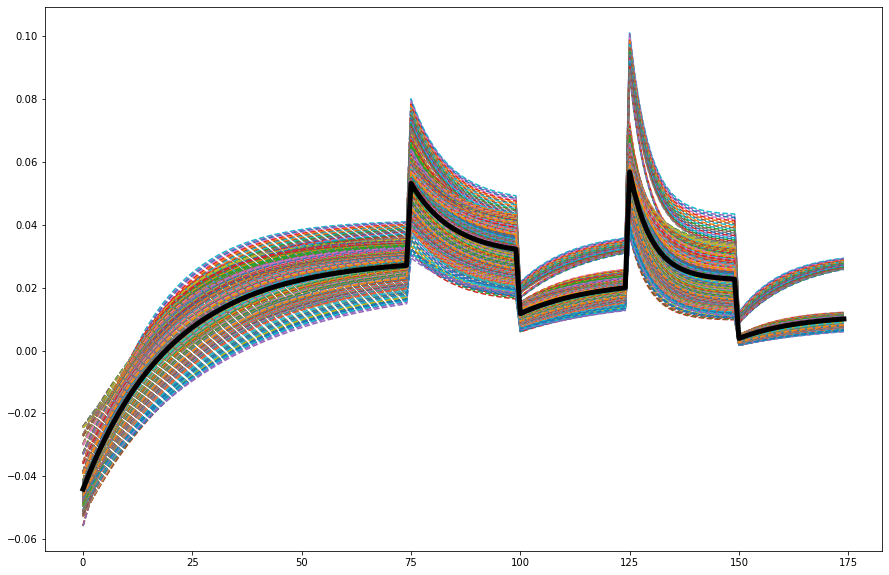

In [100]:
group_number=10
indices=group_indices_water[group_number]
mean_signal = group_signals_water[group_number]
plt.figure(figsize=(15,10))
plt.plot(water_signals[indices,:].real.T,'--');
plt.plot(mean_signal,"k-",linewidth=5)

In [85]:
res[0].shape

(31, 175)

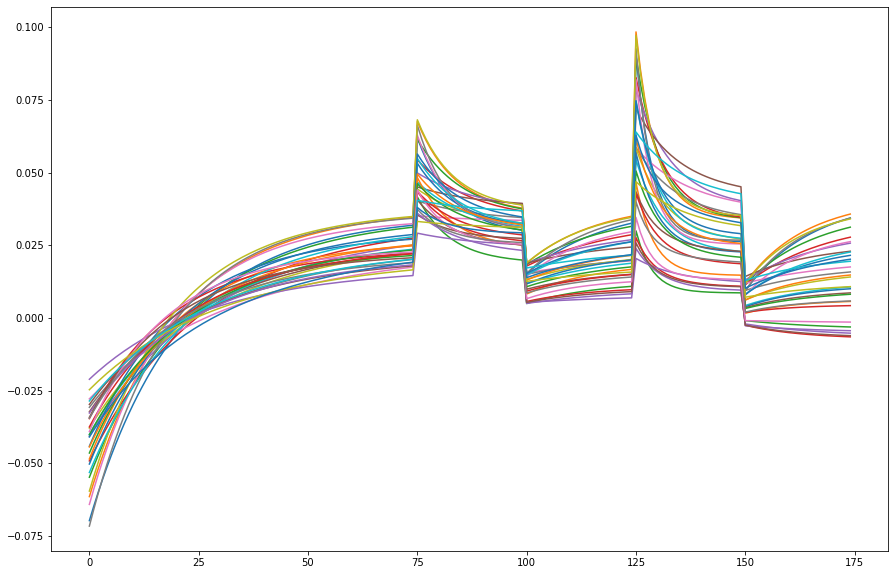

In [86]:
plt.figure(figsize=(15,10))
plt.plot(res[0].T.real)

In [20]:

threshold_pca=10
pca_water = PCAComplex(n_components_=threshold_pca)
pca_fat = PCAComplex(n_components_=threshold_pca)

pca_water.fit(water_signals)
pca_fat.fit(fat_signals)

transformed_array_water_unique = pca_water.transform(water_signals)
transformed_array_fat_unique = pca_fat.transform(fat_signals)

Not using cupy in PCA transform
Not using cupy in PCA transform


Not using cupy in PCA transform


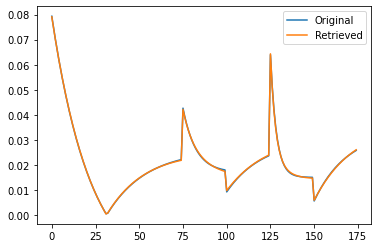

In [23]:
pca_water.plot_retrieved_signal(water_signals,i=0)

Not using cupy in PCA transform


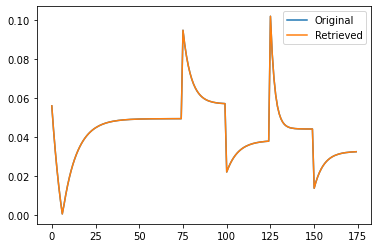

In [22]:
pca_fat.plot_retrieved_signal(fat_signals,i=0)

In [28]:
transformed_array_water_unique.real.dtype

dtype('float64')

In [29]:
from sklearn.manifold import TSNE
X=transformed_array_water_unique.real
X_embedded = TSNE(n_components=2).fit_transform(X)

In [30]:
X_embedded.shape

(15390, 2)

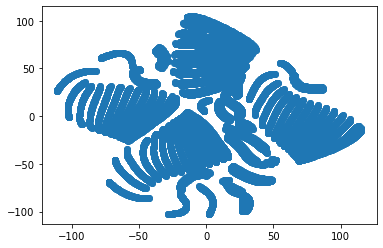

In [31]:
plt.scatter(x=X_embedded[:,0],y=X_embedded[:,1])

In [34]:
X=transformed_array_fat_unique.real
X_embedded_fat = TSNE(n_components=2).fit_transform(X)

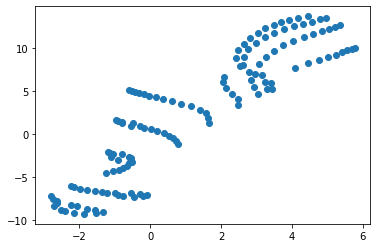

In [35]:
plt.scatter(x=X_embedded_fat[:,0],y=X_embedded_fat[:,1])

In [ ]:
from copy import copy,deepcopy
S_0 = water_signals[0].shape



S=copy(S_0)
group_signals=np.zeros((N_groups,all_paths_normalized.shape[1]))
group_indices=np.zeros((N_groups,ng))
group_pca={}
#mask = np.ones(all_paths_normalized.shape[0], dtype=bool)
index_already_assigned = []
for j in range(N_groups):
    correls=np.matmul(all_paths_normalized[:,:],S).reshape(1,-1)
    highest_correl_index = np.argsort(correls)[0]
    highest_correl_index_filtered = np.array([e for e in highest_correl_index if e not in index_already_assigned])[-ng:]
    S = np.mean(all_paths_normalized[highest_correl_index,:],axis=0)
    index_already_assigned = index_already_assigned + list(highest_correl_index_filtered)
    mask[index_already_assigned]=False
    group_signals[j,:]=S
    group_indices[j,:]=highest_correl_index_filtered
    
    X_pca_current = pca_fgm.fit_transform(all_paths_normalized[highest_correl_index_filtered,:])
    components = pca_fgm.components_
    group_pca[j]=(deepcopy(pca_fgm),X_pca_current,components)

In [ ]:
S_0 = all_paths_normalized[0,:].reshape(-1,1)
n_elements_ = 50
N_groups = int(1000/ng)
group_pruning=int(1.0*N_groups)

In [48]:
X_Y_normalized = (X_Y - mu_X_Y)/sig_X_Y

In [192]:
def pdf_multivarial_normal(x,mean,cov,hermitian=False):
    d=mean.shape[0]
    pinv_conv = np.linalg.pinv(cov,hermitian)
    
    eig_values,_ = np.linalg.eig(cov)
    pseudo_det = np.product(eig_values[eig_values > 1e-12])
    return (pseudo_det * 2*np.pi)**(-1/2)*np.exp(-0.5*np.sum((x-mean).conj()*((x-mean)@pinv_conv.T),axis=1))
    


In [185]:
x1=np.arange(0,20,0.5)
x2=np.array([0.]*x1.shape[0])
x=np.vstack( [x1,x2]).T
cov=np.array([[1,0],[0,0]])
mean=np.array([0,0])
res=pdf_multivarial_normal(x,mean,cov)

[1. 0.]


In [187]:
res

array([3.98942280e-01, 3.52065327e-01, 2.41970725e-01, 1.29517596e-01,
       5.39909665e-02, 1.75283005e-02, 4.43184841e-03, 8.72682695e-04,
       1.33830226e-04, 1.59837411e-05, 1.48671951e-06, 1.07697600e-07,
       6.07588285e-09, 2.66955661e-10, 9.13472041e-12, 2.43432053e-13,
       5.05227108e-15, 8.16623563e-17, 1.02797736e-18, 1.00779354e-20,
       7.69459863e-23, 4.57537559e-25, 2.11881925e-27, 7.64165541e-30,
       2.14638374e-32, 4.69519536e-35, 7.99882776e-38, 1.06126881e-40,
       1.09660656e-43, 8.82475497e-47, 5.53070955e-50, 2.69951302e-53,
       1.02616307e-56, 3.03790170e-60, 7.00418213e-64, 1.25767238e-67,
       1.75874954e-71, 1.91543249e-75, 1.62463604e-79, 1.07317783e-83])

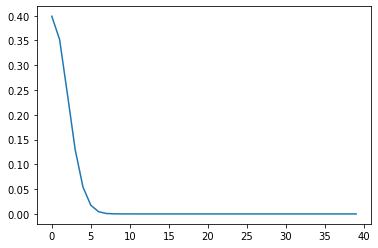

In [188]:
plt.plot(res)

In [147]:
(pinvc@(x-mean).T).shape

(40,)

In [203]:


class GMM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization.

    Parameters
    ----------
    n_components : int
        Number of clusters/mixture components in which the data will be
        partitioned into.

    n_iters : int
        Maximum number of iterations to run the algorithm.

    tol : float
        Tolerance. If the log-likelihood between two iterations is smaller than
        the specified tolerance level, the algorithm will stop performing the
        EM optimization.

    seed : int
        Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components),dtype=np.complex128)

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components,dtype=np.complex128)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False),dtype=np.complex128)

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in tqdm(range(self.n_iters)):
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            print(log_likelihood_new)
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        print("Expectation Step")
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in tqdm(range(self.n_components)):
            prior = self.weights[k]
            likelihood = pdf_multivarial_normal(X,self.means[k], self.covs[k],hermitian=True)
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""
        print("Maximization Step")
        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self



In [204]:
gmm = GMM(n_components = 20, n_iters = 10, tol = 1e-4, seed = 4)

In [205]:
np.linalg.matrix_rank(gmm.covs[0])

AttributeError: 'GMM' object has no attribute 'covs'

In [206]:
gmm.fit(X_Y)

  0%|          | 0/10 [00:00<?, ?it/s]

Expectation Step



100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Maximization Step


 10%|█         | 1/10 [00:35<05:17, 35.27s/it]

(60027462.939819284+0.0051109131702578j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Maximization Step


 20%|██        | 2/10 [01:10<04:44, 35.50s/it]

(32649902.19093457-150351.98295989932j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Maximization Step


 30%|███       | 3/10 [01:46<04:09, 35.65s/it]

(32649902.193567347-150351.98438618938j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Maximization Step


 40%|████      | 4/10 [02:22<03:33, 35.64s/it]

(32649902.1873157-150351.98620767385j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Maximization Step


 50%|█████     | 5/10 [02:57<02:57, 35.58s/it]

(32649902.190793775-150351.98286486536j)
Expectation Step



100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Maximization Step


 60%|██████    | 6/10 [03:32<02:21, 35.40s/it]

(32649902.19093457-150351.98295989932j)
Expectation Step



100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Maximization Step


 70%|███████   | 7/10 [04:07<01:45, 35.27s/it]

(32649902.193567347-150351.98438618938j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Maximization Step


 80%|████████  | 8/10 [04:43<01:10, 35.50s/it]

(32649902.1873157-150351.98620767385j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Maximization Step


 90%|█████████ | 9/10 [05:20<00:35, 35.69s/it]

(32649902.190793775-150351.98286486536j)
Expectation Step



100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Maximization Step


100%|██████████| 10/10 [05:56<00:00, 35.63s/it]

(32649902.19093457-150351.98295989932j)


/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


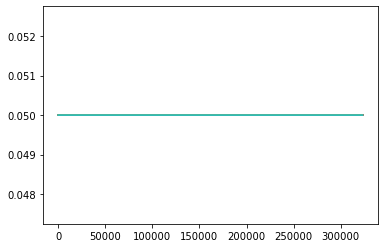

In [208]:
plt.plot(gmm.resp)

In [171]:
X_Y.shape

(323190, 179)

In [79]:
gmm.means.shape

(100, 179)

In [80]:
gmm.covs.shape

(100, 179, 179)

In [81]:
gmm.means

array([[ 6.80000000e+02+0.j        ,  3.50000000e-01+0.j        ,
        -6.00000000e-02+0.j        , ...,  6.40021174e-03-0.01241383j,
         6.40061297e-03-0.01245161j,  6.40050396e-03-0.01248644j],
       [ 6.20000000e+02+0.j        ,  7.00000000e-01+0.j        ,
         3.00000000e-02+0.j        , ...,  1.73445217e-02+0.02940641j,
         1.74981096e-02+0.02960429j,  1.76388961e-02+0.02978462j],
       [ 1.44000000e+03+0.j        ,  9.50000000e-01+0.j        ,
        -6.00000000e-02+0.j        , ...,  2.41303619e-02-0.01835263j,
         2.41687327e-02-0.0184066j ,  2.42002797e-02-0.01845428j],
       ...,
       [ 1.25000000e+03+0.j        ,  6.00000000e-01+0.j        ,
        -0.00000000e+00+0.j        , ...,  2.29217566e-02+0.00493044j,
         2.32192392e-02+0.00493805j,  2.35024611e-02+0.0049445j ],
       [ 7.20000000e+02+0.j        ,  8.00000000e-01+0.j        ,
         4.50000000e-02+0.j        , ..., -1.86857386e-03+0.03164324j,
        -1.81949397e-03+0.03189482j

In [82]:
gmm.covs

array([[[ 1.24679864e+05+0.00000000e+00j,
         -3.97129520e-14+0.00000000e+00j,
          1.54776953e-17+0.00000000e+00j, ...,
         -4.03932282e-01-3.58801118e-17j,
         -4.01699081e-01-7.73884764e-18j,
         -3.99225461e-01+1.51259295e-17j],
        [-3.97129520e-14+0.00000000e+00j,
          4.66668111e-02+0.00000000e+00j,
         -7.38570775e-20+0.00000000e+00j, ...,
          4.38899041e-04-3.00457611e-04j,
          4.45268080e-04-3.01198840e-04j,
          4.51094083e-04-3.01813685e-04j],
        [ 1.54776953e-17+0.00000000e+00j,
         -7.38570775e-20+0.00000000e+00j,
          1.50000464e-03+0.00000000e+00j, ...,
         -3.02636703e-04-5.82581806e-04j,
         -3.03105275e-04-5.87942678e-04j,
         -3.03499933e-04-5.92965736e-04j],
        ...,
        [-4.03932282e-01+3.58801118e-17j,
          4.38899041e-04+3.00457611e-04j,
         -3.02636703e-04+5.82581806e-04j, ...,
          5.08688975e-04+0.00000000e+00j,
          5.12627024e-04+7.39647930e-07j

In [83]:
np.min(np.abs(X_Y))

0.0

In [84]:
gmm.weights

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01])

In [85]:
multivariate_normal(gmm.means[0],gmm.covs[0])

LinAlgError: singular matrix

In [86]:
np.all(np.linalg.eigvals(gmm.covs[0]) > 0)

False

/home/cslioussarenko/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


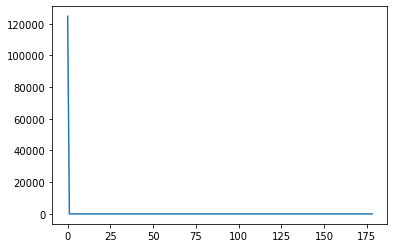

In [88]:
plt.plot(np.linalg.eigvals(gmm.covs[1]))